In [1]:
import albumentations as A
import torch
import os
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp

from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from dataloaders import BalloonDatasetSegmentation, BalloonLoaders
from json_to_masks import create_labels
from utils import *

## Create masks

In [2]:
create_labels('train')
create_labels('val')

## Augmentations

In [3]:
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),      
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),
        A.ShiftScaleRotate(scale_limit=0.5, 
                            rotate_limit=0, 
                            shift_limit=0.1, 
                            p=1, 
                            border_mode=0),
        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [4]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps=1., activation = None),
]

In [5]:
class My_network():
    
    
    def __init__(self, loss, metrics):
        self.model = smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=1, 
            activation=ACTIVATION,
        )
        
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=0.0001),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=False,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
        
        
    def run_training(self, loaders, n_epochs=40, save_name='./best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):

            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)

            if i%10==0: 
                print(f'==Epoch {i}==')
                print('Train/Val IoU:')
                print(round(train_logs['iou_score'] , 2))
                print(round(valid_logs['iou_score'] , 2))

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)
    
    def eval(self, dataloader, model_path='./best_model.pth'):
        best_model = torch.load(model_path)
        test_epoch = smp.utils.train.ValidEpoch(
                         model=best_model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

        logs = test_epoch.run(dataloader)
        return best_model

In [6]:
network = My_network(loss, metrics)

C:\Users\rosotosya\anaconda3\envs\my-ml-env\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


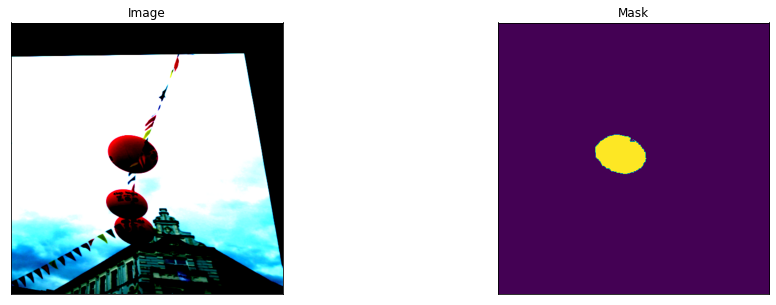

In [7]:
balloon_loaders = BalloonLoaders(augmentation=get_training_augmentation(), 
                                 preprocessing_fn=preprocessing_fn)
balloon_loaders.show_example()

In [14]:
network.run_training(balloon_loaders, n_epochs=20)

==Epoch 0==
Train/Val IoU:
0.65
0.46
==Epoch 10==
Train/Val IoU:
0.88
0.78


In [15]:
best_model = network.eval(balloon_loaders.test_loader)

valid: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s, dice_loss - 0.3741, iou_score - 0.8495]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


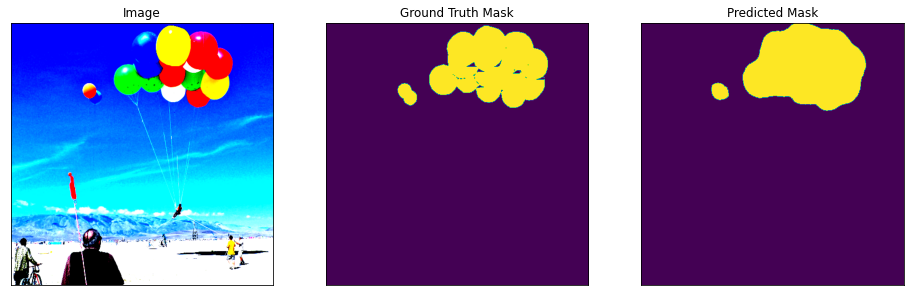

In [16]:
compare_predictions(balloon_loaders, best_model)

## Without augmentations

In [17]:
network_without_aug = My_network(loss, metrics)
balloon_loaders = BalloonLoaders(augmentation=None, preprocessing_fn=preprocessing_fn)

network_without_aug.run_training(balloon_loaders, n_epochs=20, 
                                 save_name='./best_model_without_aug.pth')

==Epoch 0==
Train/Val IoU:
0.2
0.23
==Epoch 10==
Train/Val IoU:
0.84
0.7


In [18]:
best_model = network_without_aug.eval(balloon_loaders.test_loader, 
                                      model_path='./best_model_without_aug.pth')

valid: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, dice_loss - 0.2704, iou_score - 0.8796]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


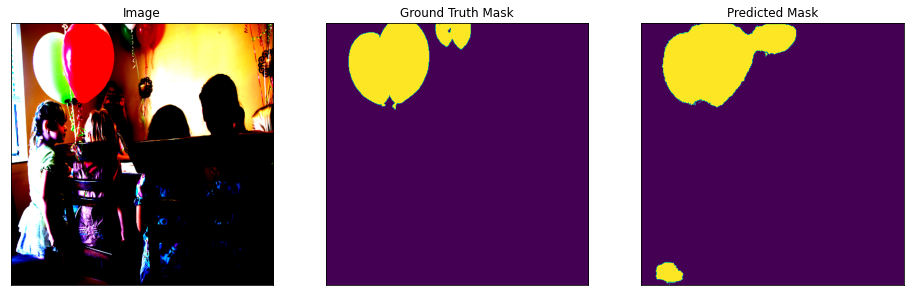

In [19]:
for _ in range(1):
    compare_predictions(balloon_loaders, best_model)